In [1]:
# Generate Gaussian data for our numerical simulation and then normalize it
import scipy
import numpy as np
num_samples = 2000
dimension = 50
X = np.reshape(np.random.normal(size=num_samples*dimension), (num_samples, dimension))
Y = np.random.normal(size=num_samples, scale=1)
mu = np.average(X, axis=0)
av_X = X - np.reshape(mu, (1, dimension))
Sigma = av_X.transpose() @ av_X
root_Sigma = scipy.linalg.sqrtm(Sigma)
norm_X = av_X @ np.linalg.inv(root_Sigma)
norm_Y = Y - np.average(Y)
X = norm_X
Y = norm_Y

In [2]:
# Compute the linear fit and error bar on our axis of interest. Compute the Xe and Xr arrays and the Xer vector
from src.utils.linear_algebra import compute_ols_and_error

beta, beta_error_bars = compute_ols_and_error(X, Y)
residuals = Y - (X @ beta)

axis_of_interest = np.concatenate(([1], np.zeros(dimension - 1)))

XR = residuals[:, np.newaxis] * X
Xe = (X @ axis_of_interest)[:, np.newaxis] * X
Xer = XR @ axis_of_interest

# In this example, we are interested in attacks that *increase* the fit parameter.
# Therefore, it makes sense to try to get bounds on an effective Gram matrix G such that
# 1_T ^T G 1_T = sum_{i \in T} <X_i, e> R_i
# The problem is that some of these summands may be negative. Therefore, G might not be PSD.
# However, this is not so problematic for us as none of the algorithmic components we wish to apply here depend strongly on G being PSD (the only part that needs to change is to call eig instead of eigh).
gram_matrix_xer = np.diag(Xer)

# A bad idea. Disregard:
# Therefore, we define the "effective Gram matrix" of Xer as <1_T, G_Xer, 1_T> = (\sum_{i \in T st Xer_i > 0} Xer_i)^2 - (\sum_{i \in T st Xer_i < 0} Xer_i)^2
# Taking this norm is useful, since sqrt(<1_T, G_Xer, 1_T>) = sqrt((\sum_{i \in T st Xer_i > 0} Xer_i)^2 - (\sum_{i \in T st Xer_i < 0} Xer_i)^2) > (\sum_{i \in T st Xer_i > 0} Xer_i) + (\sum_{i \in T st Xer_i < 0} Xer_i) = \sum_{i \in T } Xer_i
# The downside to taking this norm is that this effective gram matrix is not

In [3]:
# Here we begin computing our bounds. We use the direct reduction from P1 to P2 by G_P1 = abs(G_P2)^2
# We feed this effective Gram matrix into spectral and triangle based bounds.
from src.geometric_algorithms.spectral_algorithms import spectral_bound_sum_ips_squared, spectral_bound_sum_ips
from src.geometric_algorithms.triangle_inequality import refined_triangle_inequality_ips, refined_triangle_inequality_ips_squared

from matplotlib import pyplot as plt

gram_matrix_CS = X @ X.transpose()
ips_squared_bound_triangle = refined_triangle_inequality_ips_squared(gram_matrix_CS)
ips_squared_bound_spectral = spectral_bound_sum_ips_squared(
    gram_matrix=gram_matrix_CS,
    d=dimension,
    k_vals=np.arange(1, num_samples)
)

100%|██████████| 1999/1999 [00:00<00:00, 36005.16it/s]


In [4]:
# Here we use the approach of Freund and Hopkins hypercontractivity bound to compute a different effective gram matrix for our P1 -> P2 reduction. 
from src.geometric_algorithms.hypercontractivity_reduction import bound_42_hypercontractivity_gm
ks = np.arange(1, num_samples)
epsilons = ks / num_samples

hyper_gram_matrix = bound_42_hypercontractivity_gm(X)
eigvals_hyper, eigvecs_hyper = np.linalg.eigh(hyper_gram_matrix)
hypercontractivity_bound = num_samples * max(eigvals_hyper)

ips_squared_bound_hypercontractivity = np.sqrt(epsilons * hypercontractivity_bound) 
ips_squared_bound_hyper_spectral = spectral_bound_sum_ips(
    gram_matrix=hyper_gram_matrix,
    d=int(min((dimension**2 + dimension)/2, num_samples)),
    k_vals = ks,
    eigvals=eigvals_hyper,
    eigvecs=eigvecs_hyper
)

ips_squared_bound_hyper_triangle = refined_triangle_inequality_ips(gram_matrix_CS)

100%|██████████| 1999/1999 [00:00<00:00, 26475.65it/s]


In [5]:
# Here we generate a greedy lower bound on the possible covariance shifts. 
# We do this by greedily selecting the longest samples from X and then using an eigenvalue decomposition to compute their covariance shifts.

import tqdm
# Sort rows by norm length
row_norms = np.linalg.norm(norm_X, axis=1)
sorted_indices = np.argsort(-row_norms)  # Sort indices in descending order
sorted_norm_X = norm_X[sorted_indices]

# Compute the largest eigenvalue for each l
largest_eigenvalues = [np.linalg.eigvalsh(sorted_norm_X[:l, :].T @ sorted_norm_X[:l, :]).max() for l in tqdm.trange(1, num_samples)]

100%|██████████| 1999/1999 [00:00<00:00, 4327.59it/s]


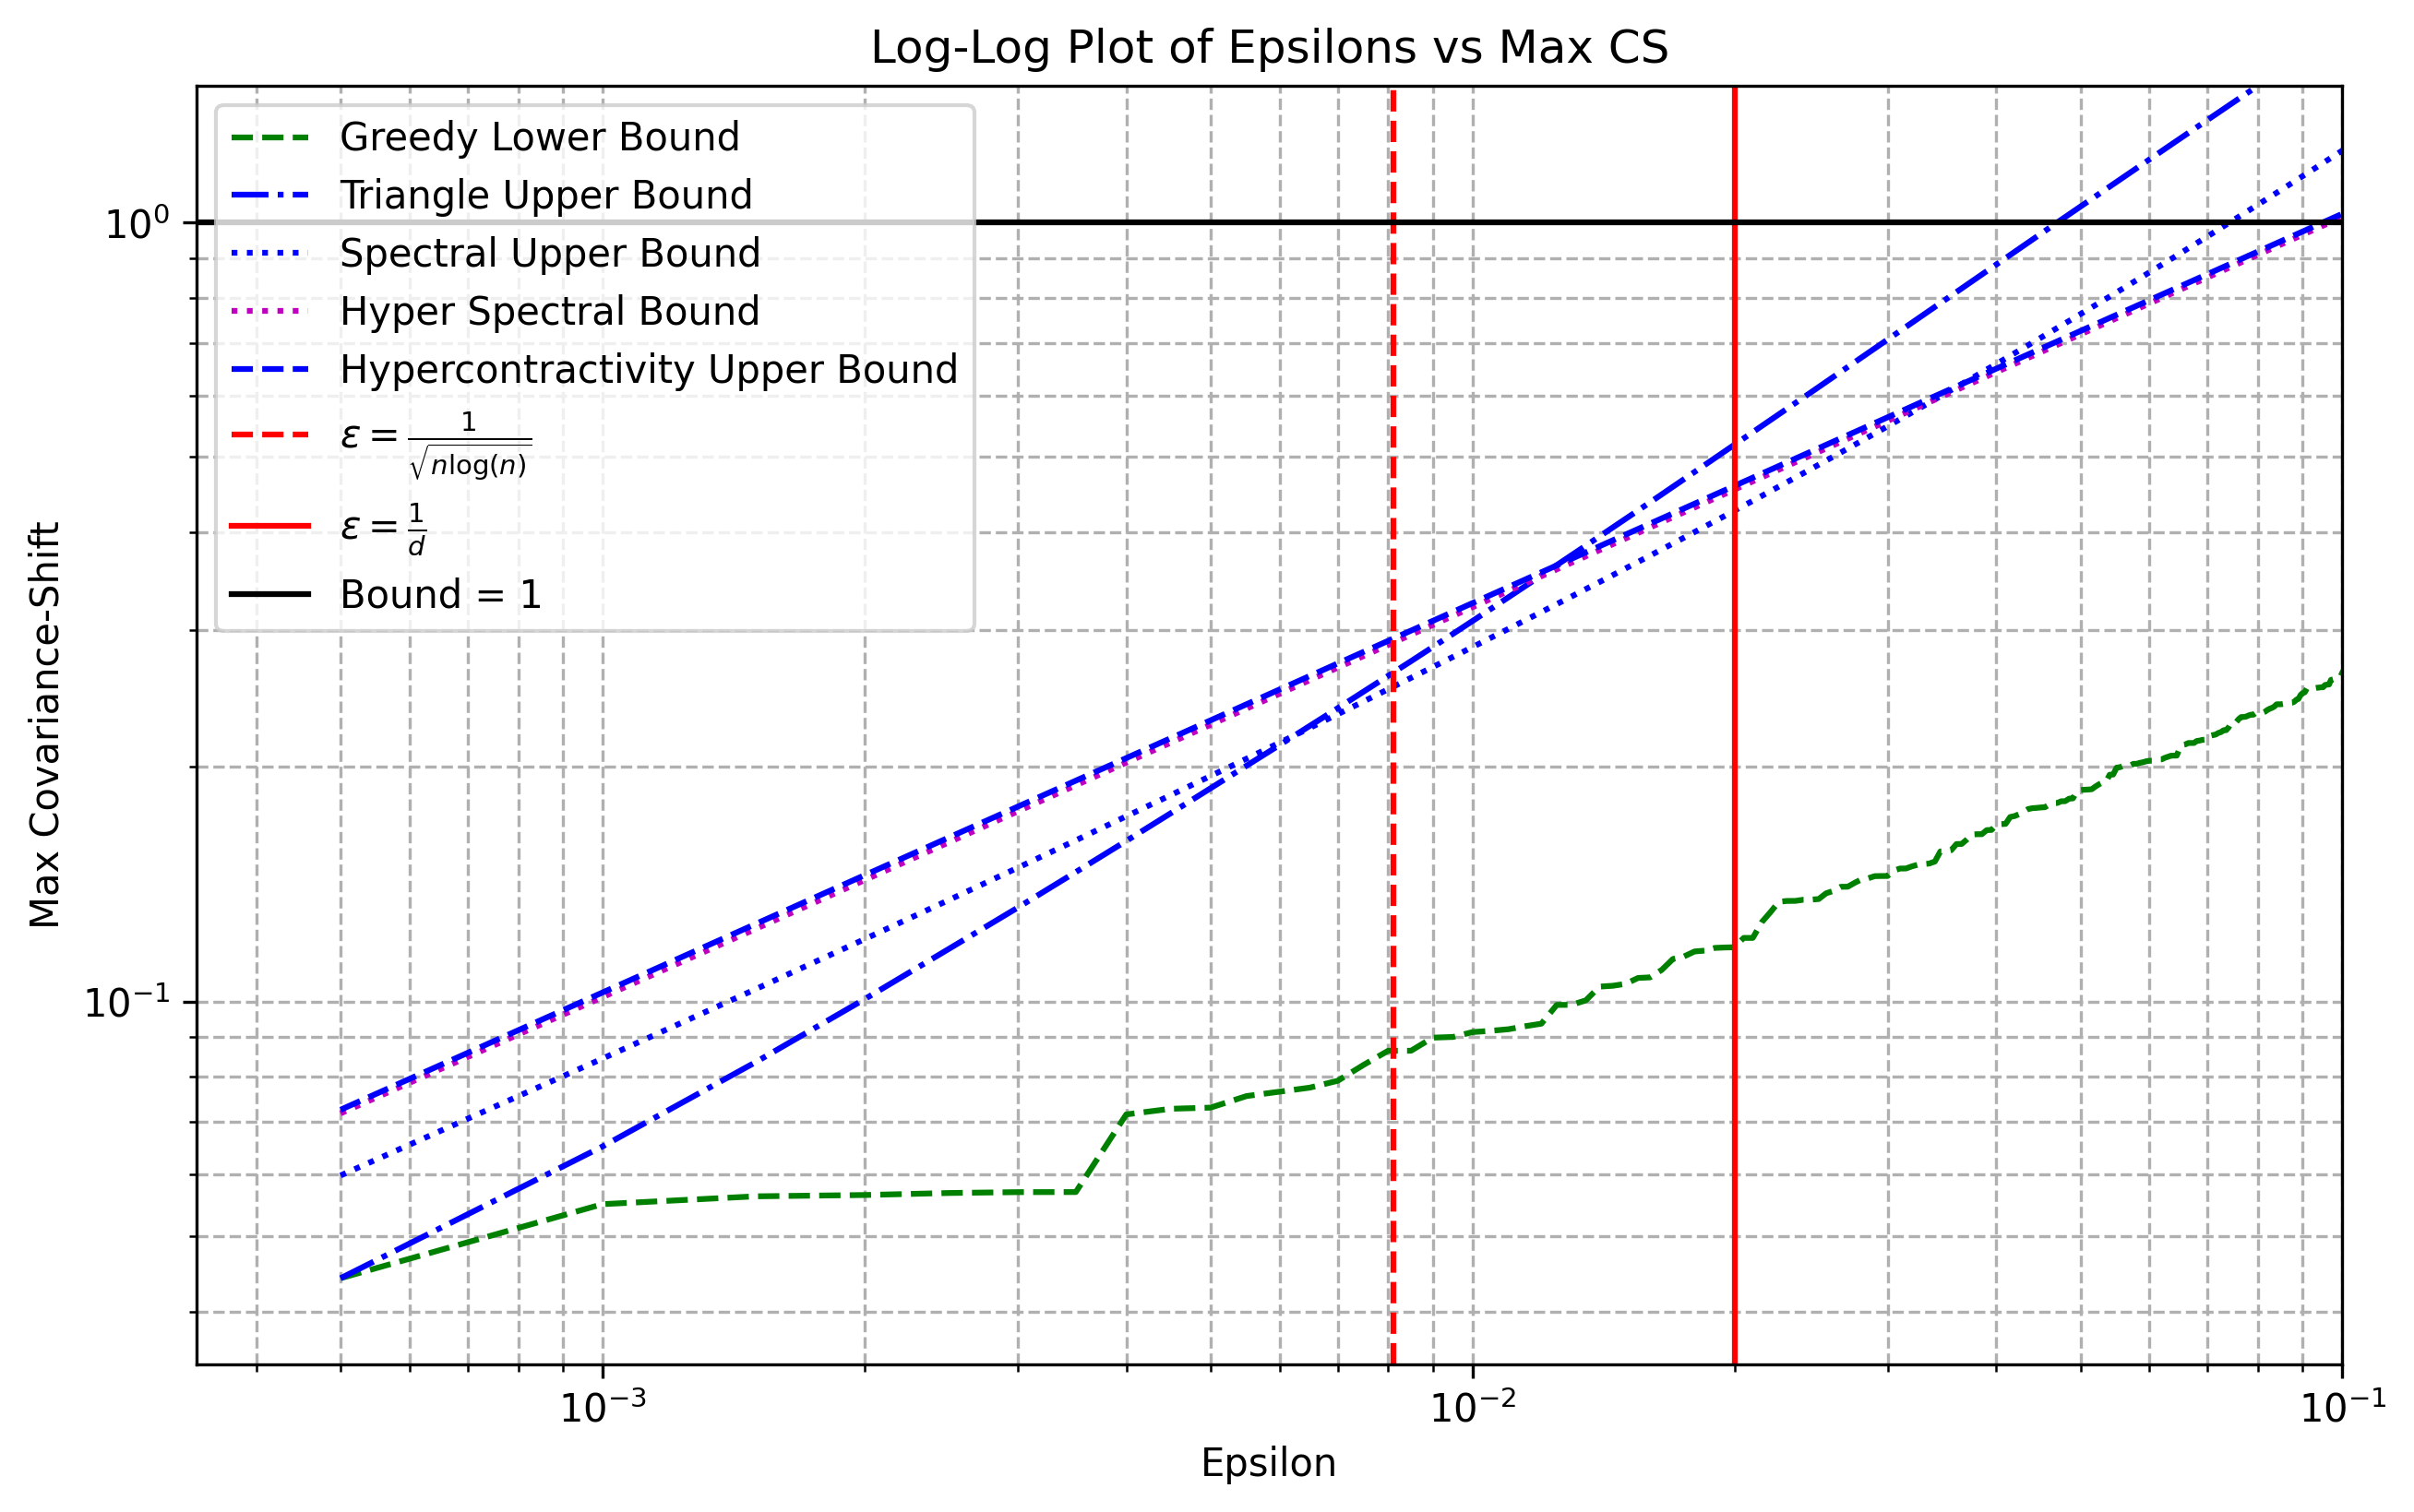

In [6]:
# Plot the resulting bounds on the covariance shift

plt.figure(figsize=(10, 6), dpi=300)
plt.loglog(epsilons[:len(largest_eigenvalues)], largest_eigenvalues, '--g', label='Greedy Lower Bound')
plt.loglog(epsilons, ips_squared_bound_triangle, '-.b', label='Triangle Upper Bound')
plt.loglog(
    epsilons, 
    ips_squared_bound_spectral, 
    ':b', label='Spectral Upper Bound'
)


plt.loglog(
    epsilons, 
    ips_squared_bound_hyper_spectral, 
    ':m', label='Hyper Spectral Bound'
)

plt.loglog(
    epsilons, 
    ips_squared_bound_hypercontractivity, 
    '--b', label='Hypercontractivity Upper Bound'
)
plt.axvline(x=1/np.sqrt(num_samples*np.log(num_samples)), color='r', linestyle='--', label=r'$\varepsilon = \frac{1}{\sqrt{n \log(n)}}$')
plt.axvline(x=1/dimension, color='r', linestyle='-', label=r'$\varepsilon = \frac{1}{d}$')

plt.axhline(y=1, color='k', linestyle='-', label=r'Bound = 1')


plt.xlabel('Epsilon')
plt.ylabel('Max Covariance-Shift')
plt.title('Log-Log Plot of Epsilons vs Max CS')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.ylim(plt.ylim()[0], 1.5)
plt.xlim(plt.xlim()[0], 0.1)
plt.show()

In [7]:
# Compute the Gram matrix of the XR vectors (samples renormalized by their residuals).
# Use spectral and triangle based algorithms to bound the lengths of their sums.

gram_matrix_XR = XR @ XR.transpose()
sum_ips_XR_triangle = refined_triangle_inequality_ips(gram_matrix=gram_matrix_XR)
sum_ips_XR_spectral = spectral_bound_sum_ips(
    gram_matrix=gram_matrix_XR,
    d=dimension,
    k_vals=np.arange(1, num_samples)
)

100%|██████████| 1999/1999 [00:00<00:00, 31041.77it/s]


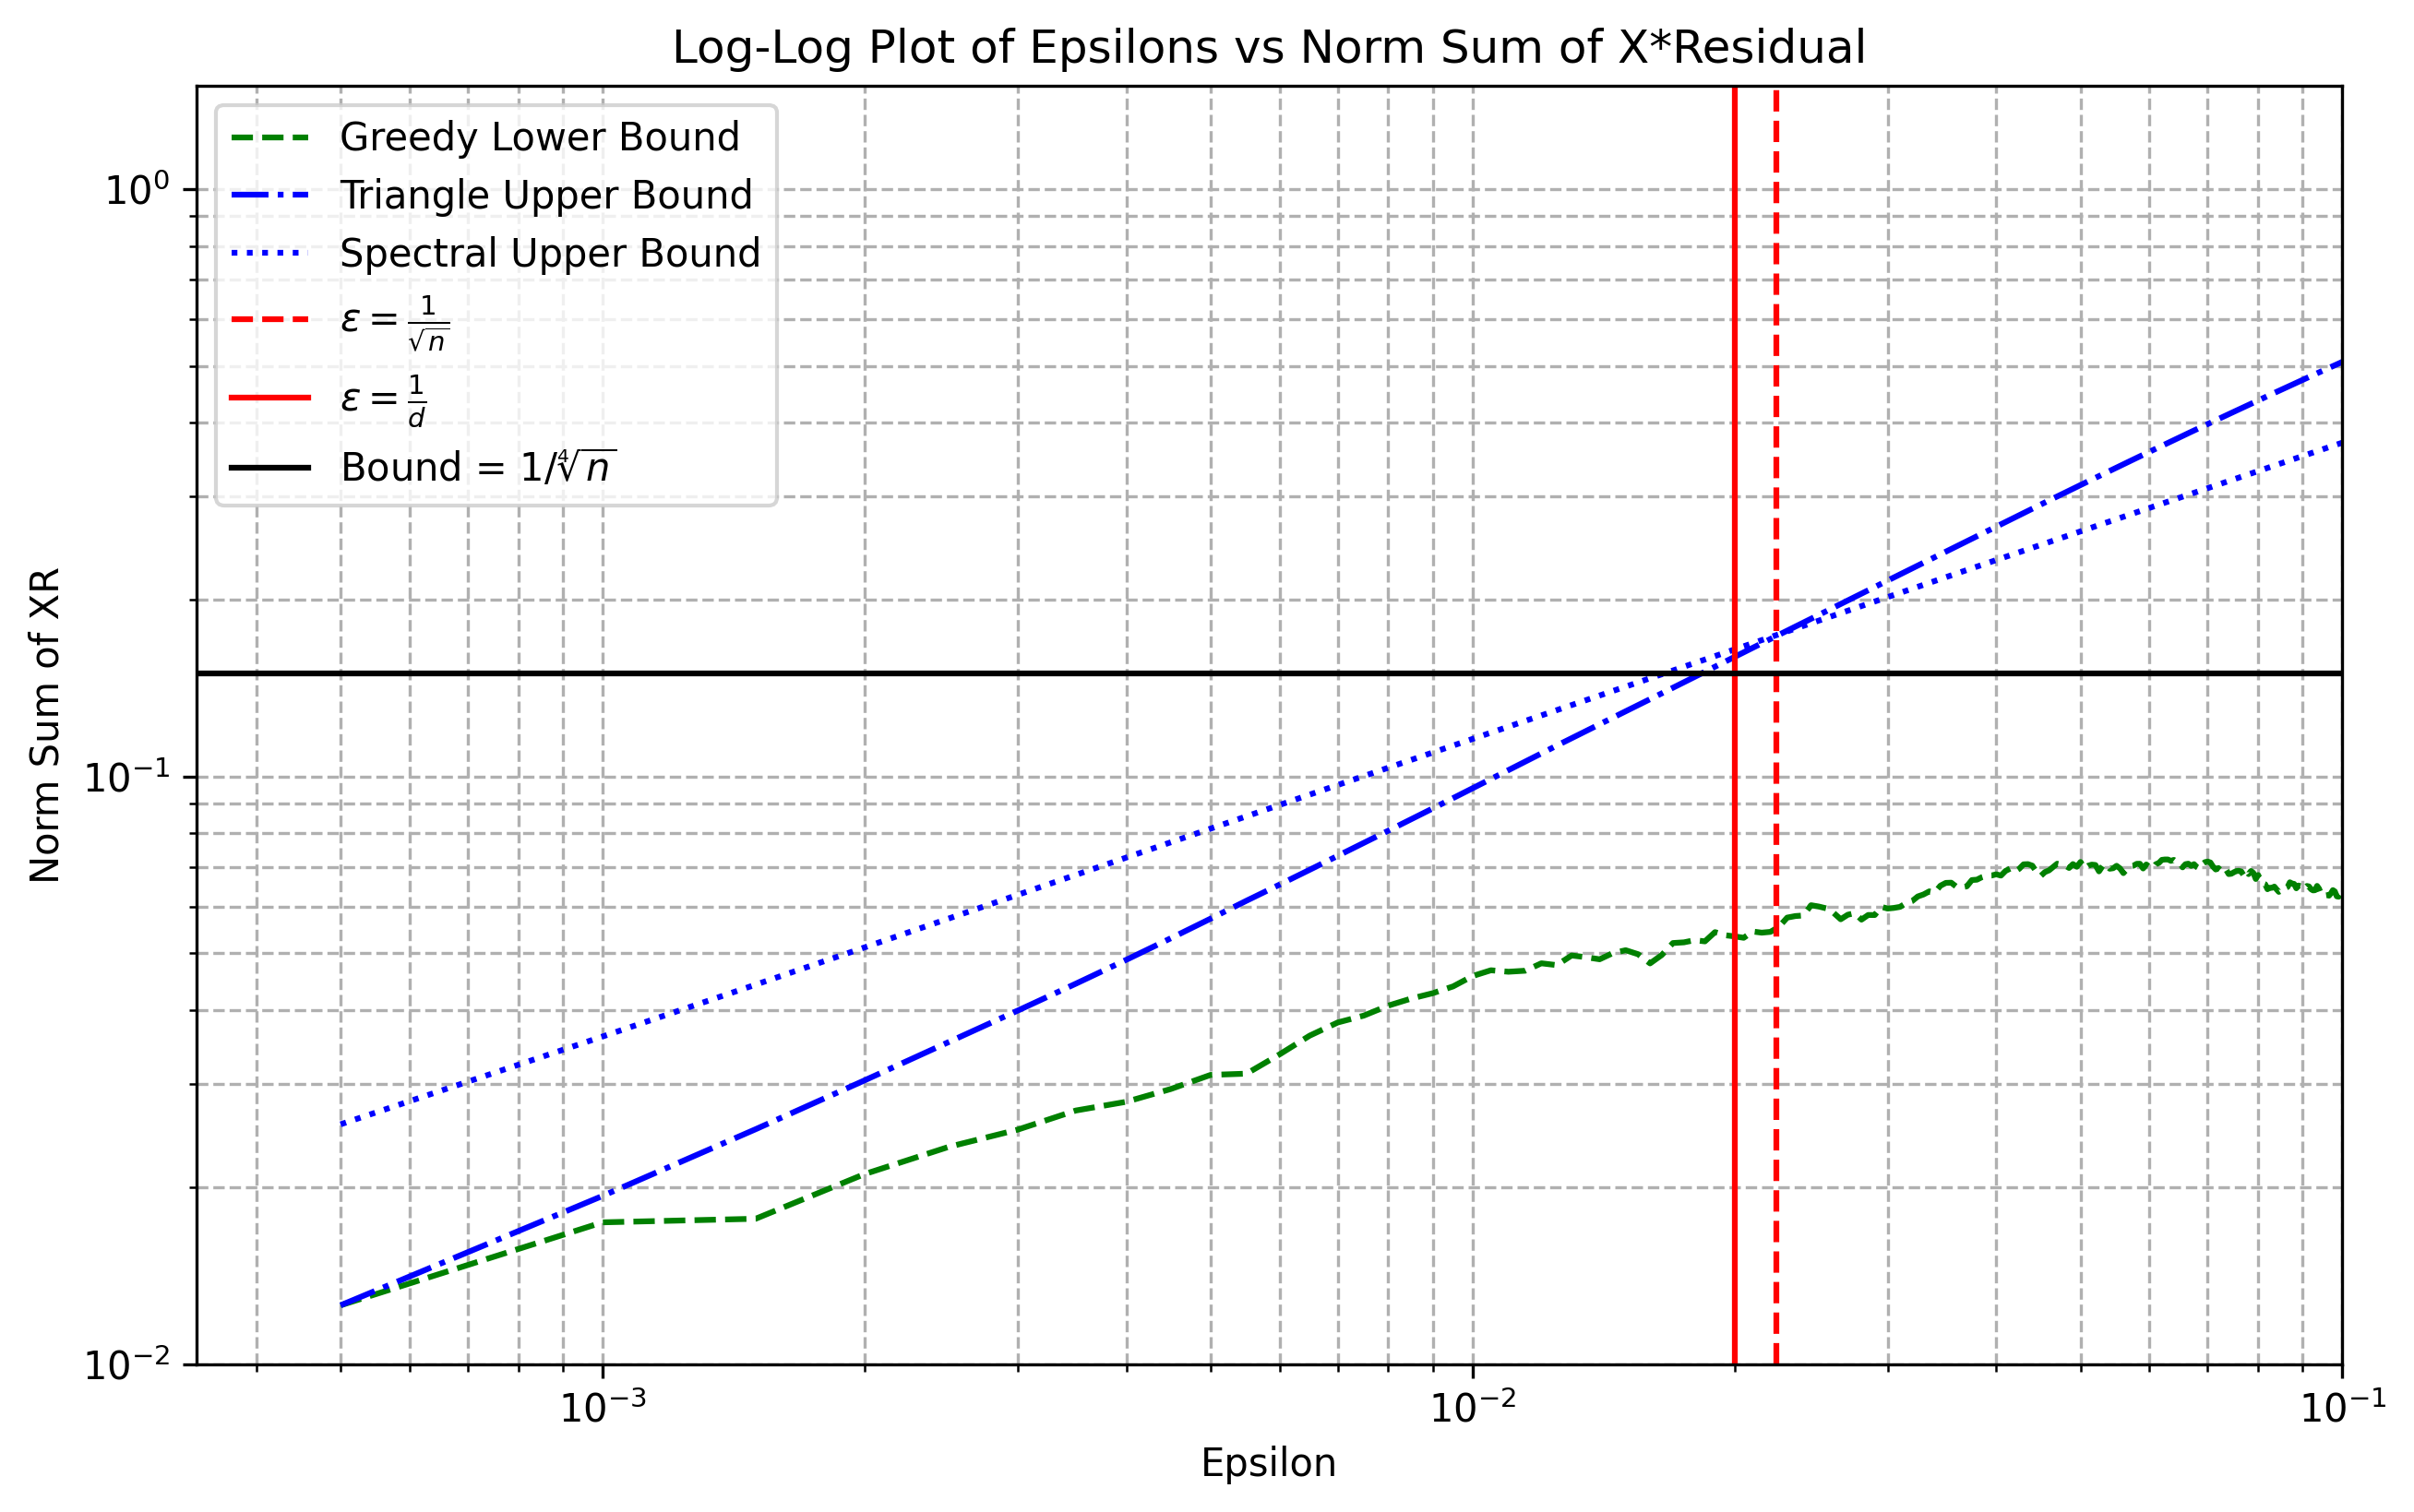

In [8]:
# Plot the resulting bounds.
# TODO: Try to generate a lower bound via spectral analysis for a better baseline. 

plt.figure(figsize=(10, 6), dpi=300)
diag_order = np.argsort(np.diag(gram_matrix_XR))[::-1]
plt.loglog(epsilons, np.linalg.norm(np.cumsum(XR[diag_order, :], axis=0), axis=1)[:-1] * np.sqrt(1 / num_samples), '--g', label='Greedy Lower Bound')
plt.loglog(epsilons, sum_ips_XR_triangle * np.sqrt(1 / num_samples), '-.b', label='Triangle Upper Bound')
plt.loglog(
    epsilons[:len(sum_ips_XR_spectral)], 
    sum_ips_XR_spectral * np.sqrt(1 / num_samples), 
    ':b', label='Spectral Upper Bound'
)

plt.axvline(x=1/np.sqrt(num_samples), color='r', linestyle='--', label=r'$\varepsilon = \frac{1}{\sqrt{n}}$')
plt.axvline(x=1/dimension, color='r', linestyle='-', label=r'$\varepsilon = \frac{1}{d}$')

plt.axhline(y=1/(num_samples ** 0.25), color='k', linestyle='-', label=r'Bound = $1 / \sqrt[4]{n}$')


plt.xlabel('Epsilon')
plt.ylabel('Norm Sum of XR')
plt.title('Log-Log Plot of Epsilons vs Norm Sum of X*Residual')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.ylim(1E-2, 1.5)
plt.xlim(plt.xlim()[0], 0.1)
plt.show()

In [9]:
# Similarly bound Norm_2 {sum_{i in T} <X_i, e> X_i}

from src.geometric_algorithms.spectral_algorithms import spectral_bound_sum_ips

gram_matrix_Xe = Xe @ Xe.transpose()
sum_ips_Xe_triangle = refined_triangle_inequality_ips(gram_matrix=gram_matrix_Xe)
sum_ips_Xe_spectral = spectral_bound_sum_ips(
    gram_matrix=gram_matrix_Xe,
    d=dimension,
    k_vals=np.arange(1, num_samples)
)
sum_ips_Xe_spectral_improved = sum_ips_Xe_spectral


100%|██████████| 1999/1999 [00:00<00:00, 36332.97it/s]


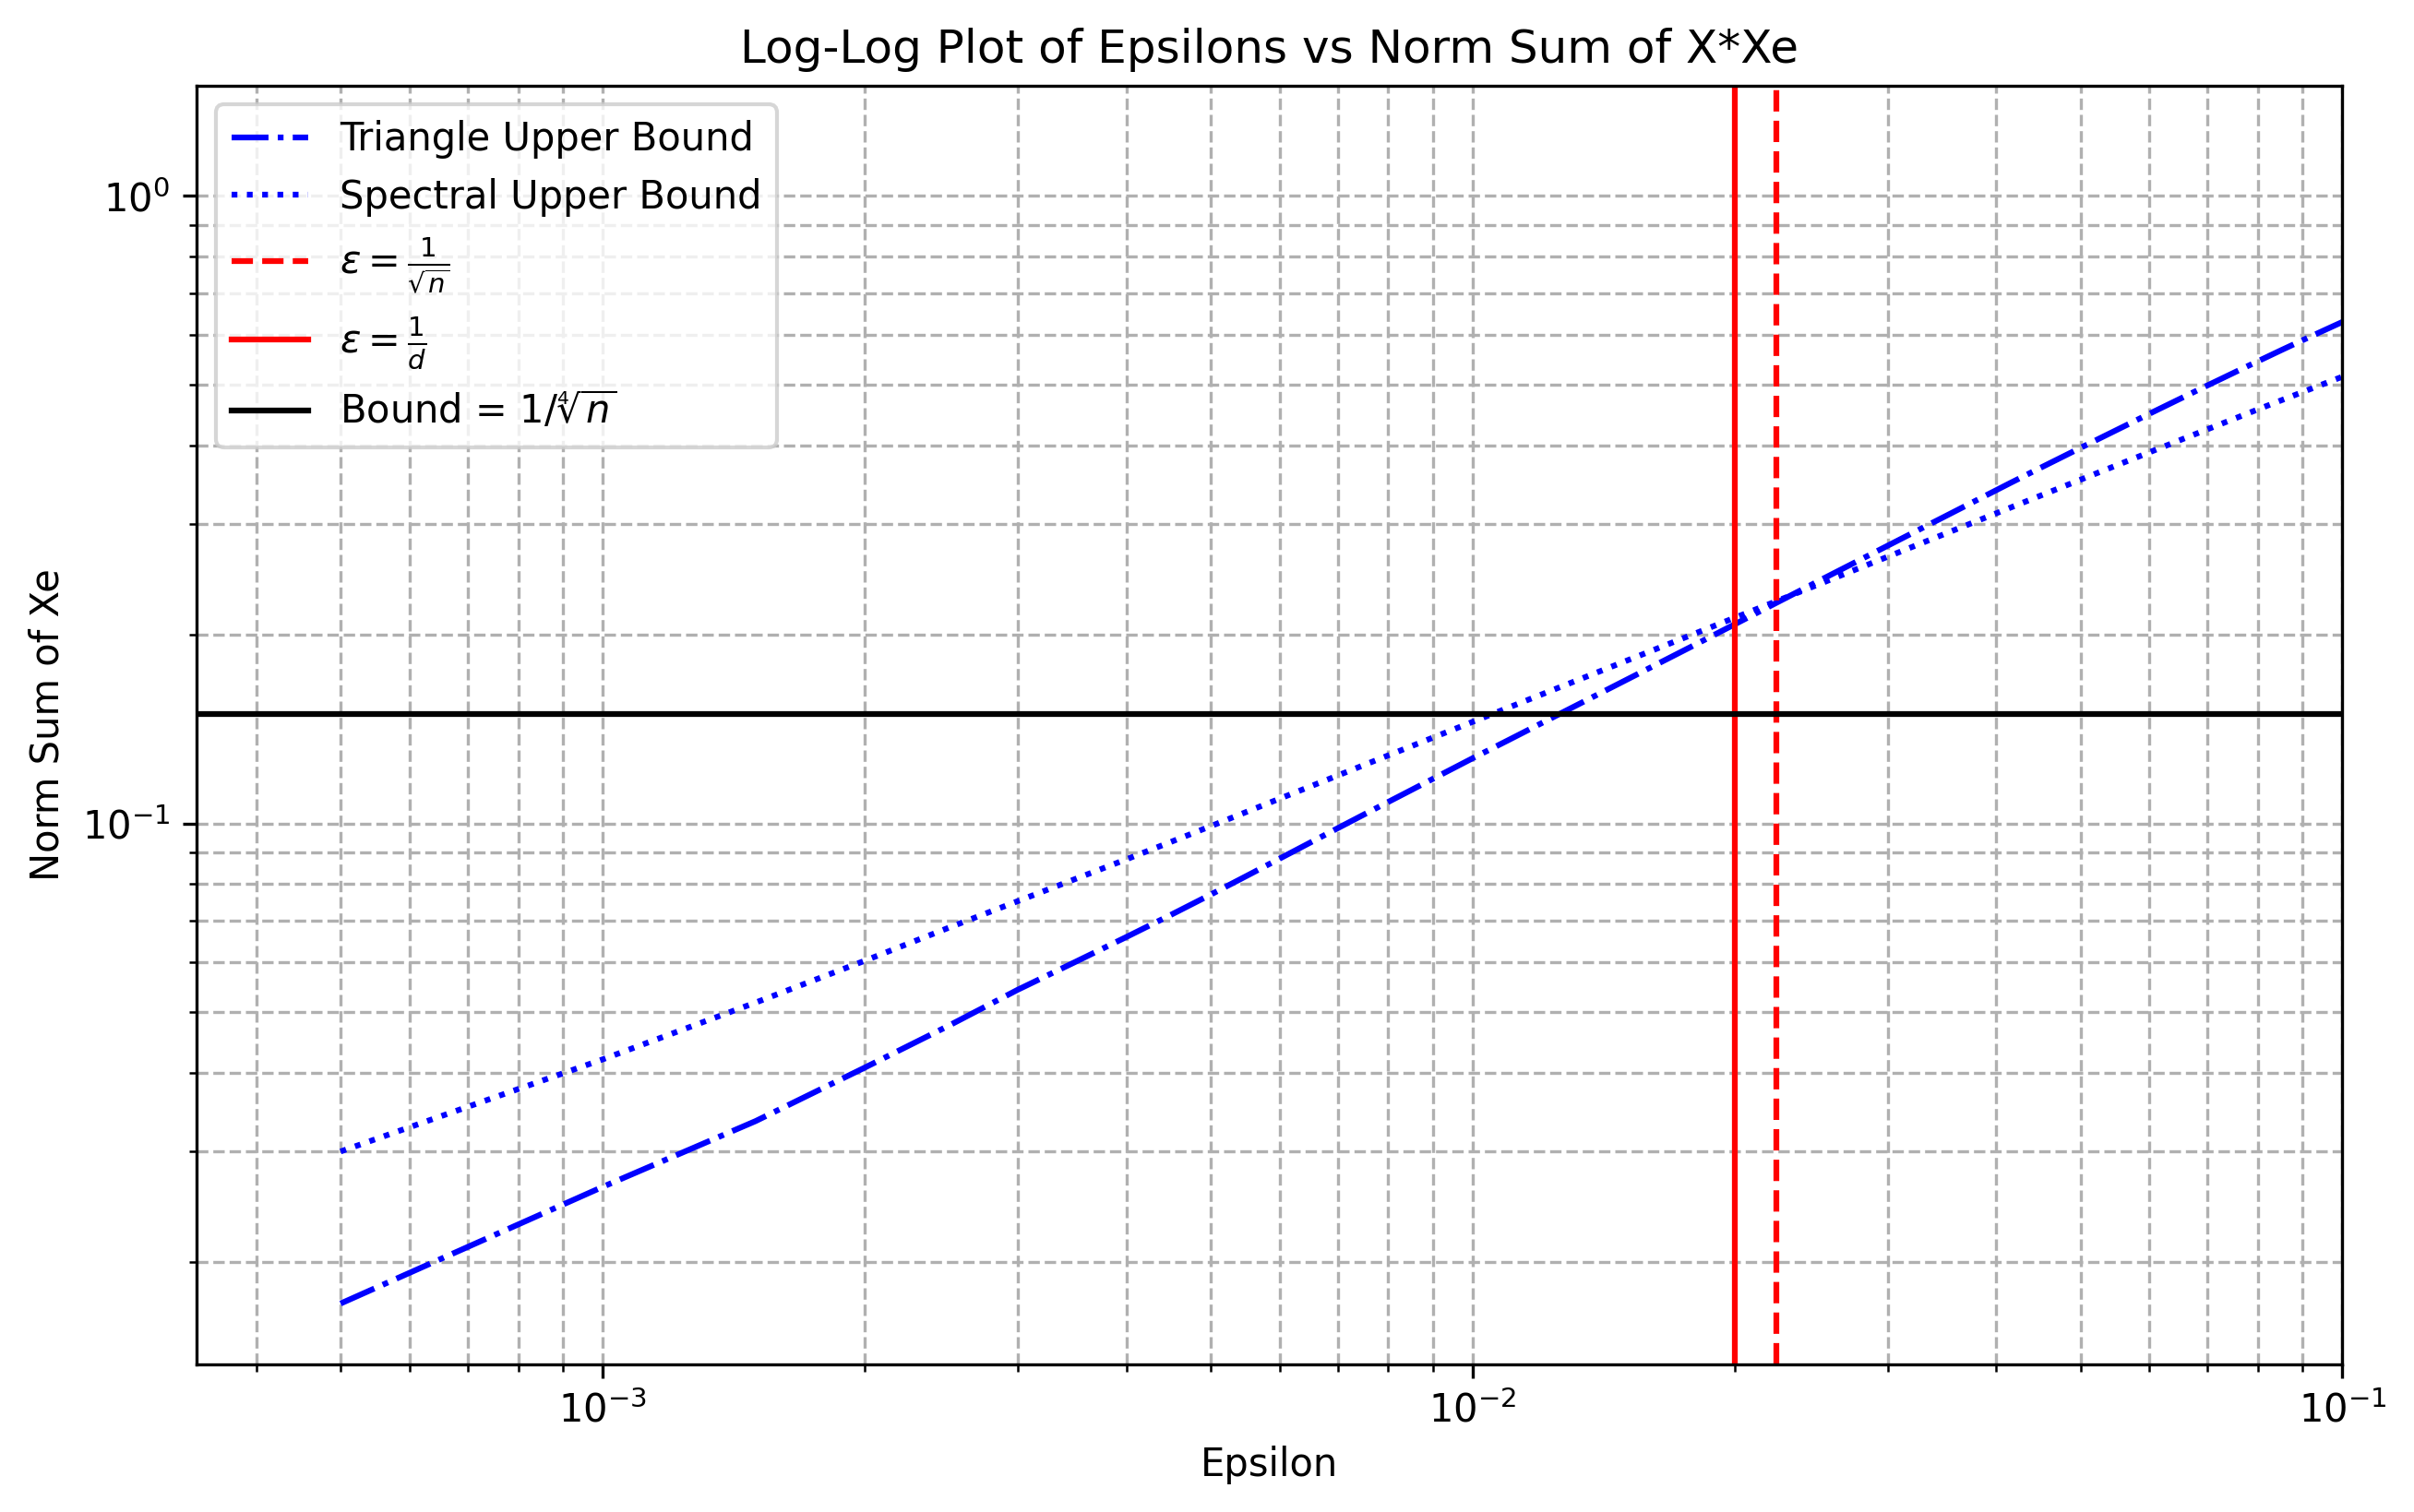

In [10]:
plt.figure(figsize=(10, 6), dpi=300)
ks = np.arange(1, num_samples)
epsilons = ks / num_samples
plt.loglog(epsilons, sum_ips_Xe_triangle, '-.b', label='Triangle Upper Bound')
plt.loglog(epsilons, sum_ips_Xe_spectral, ':b', label='Spectral Upper Bound')

plt.axvline(x=1/np.sqrt(num_samples), color='r', linestyle='--', label=r'$\varepsilon = \frac{1}{\sqrt{n}}$')
plt.axvline(x=1/dimension, color='r', linestyle='-', label=r'$\varepsilon = \frac{1}{d}$')

plt.axhline(y=1/(num_samples ** 0.25), color='k', linestyle='-', label=r'Bound = $1 / \sqrt[4]{n}$')


plt.xlabel('Epsilon')
plt.ylabel('Norm Sum of Xe')
plt.title('Log-Log Plot of Epsilons vs Norm Sum of X*Xe')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.ylim(plt.ylim()[0], 1.5)
plt.xlim(plt.xlim()[0], 0.1)
plt.show()

In [11]:
# Gather all the bounds we have generated so far and combine them to find the best bound on each of the effects individually. 
CS_bounds = np.concatenate(
    (
        ips_squared_bound_spectral[:, np.newaxis],
        ips_squared_bound_triangle[:, np.newaxis],
        ips_squared_bound_hypercontractivity[:, np.newaxis],
        ips_squared_bound_hyper_spectral[:, np.newaxis],
        # ips_squared_bound_hyper_spectral_improved[:, np.newaxis],
    ), axis=1
)
CS_bound = np.min(CS_bounds, axis=1)

sum_ips_Xe_bounds = np.concatenate(
    (
        sum_ips_Xe_spectral[:, np.newaxis],
        sum_ips_Xe_triangle[:, np.newaxis]
    ), axis=1
)
sum_ips_Xe_bound = np.min(sum_ips_Xe_bounds, axis=1)

sum_ips_XR_bounds = np.concatenate(
    (
        sum_ips_XR_spectral[:, np.newaxis],
        sum_ips_XR_triangle[:, np.newaxis],
        # sum_ips_XR_hyper_spectral[:, np.newaxis]
    ), axis=1
)
sum_ips_XR_bound = np.min(sum_ips_XR_bounds, axis=1)
covariance_bound = (1 / (1 - CS_bound)) * np.min(sum_ips_XR_bounds, axis=1) * np.min(sum_ips_Xe_bounds, axis=1)
# Directly bound the residual attacks by taking the influence on the relevant axis of the mean estimation:
residual_attacks = np.cumsum(-np.sort(-(residuals[:, np.newaxis] * X @ axis_of_interest)))[:-1]

In [12]:
# Replicate the Freund and Hopkins analysis as a baseline:
C1 = np.max(np.linalg.eigvalsh(gram_matrix_XR))
C2 = np.max(eigvals_hyper) * num_samples
freund_and_hopkins = np.sqrt(C1 * epsilons * num_samples) / (1 - np.sqrt(C2 * epsilons))

In [13]:
# Bound XeXR = Norm{sum_{i in T} <X_i, e> X_i} * Norm{sum_{i in T} R_i X_i}
# So far we have bounded each of these terms separately, but we may instead bound:
# Norm{sum_{i in T} <X_i, e> X_i}^2 + Norm{sum_{i in T} R_i X_i}^2 >= 2*XeXR
# We can bound the LHS because that is also a problem 1, and we expect to get good bounds there, since <X_i, e> and R_i are uncorrelated.

idx = int(np.sqrt(num_samples))
XeXR_ratio = sum_ips_Xe_spectral[idx] / sum_ips_XR_spectral[idx]
gram_matrix_XeXR = (XeXR_ratio * gram_matrix_XR + (1 / XeXR_ratio) * gram_matrix_Xe)
XeXR_bound_spectral = spectral_bound_sum_ips(
    gram_matrix=gram_matrix_XeXR,
    d=dimension*2,
    k_vals=ks
)
XeXR_bound_spectral = 0.5 * (XeXR_bound_spectral ** 2)

XeXR_bound_triangle = refined_triangle_inequality_ips(
    gram_matrix=gram_matrix_XeXR
)
XeXR_bound_triangle = 0.5 * (XeXR_bound_triangle ** 2)

XeXR_bound = np.minimum(
    XeXR_bound_triangle,
    XeXR_bound_spectral
)

100%|██████████| 1999/1999 [00:00<00:00, 11592.18it/s]


In [14]:
# Bound XeXR + CS^2
# Similar to the analysis above, we bound a linear combination of Xe^2, XR^2, CS^2
# This bound will then be inserted into an analysis to bound XeXR / (1 - CS).
XeXR_to_CS_ratio = CS_bound[idx] / XeXR_bound[idx]
XeXR_CS_gm_spectral = (XeXR_to_CS_ratio * gram_matrix_XeXR) + hyper_gram_matrix
XeXR_CS_bound_spectral = spectral_bound_sum_ips(
    gram_matrix=XeXR_CS_gm_spectral,
    d=min(num_samples, (dimension**2) + (3*dimension)),
    k_vals=ks
) ** 2

XeXR_CS_gm_triangle = (XeXR_to_CS_ratio * gram_matrix_XeXR) + gram_matrix_CS
XeXR_CS_bound_triangle = refined_triangle_inequality_ips(
    gram_matrix=XeXR_CS_gm_triangle
) ** 2

XeXR_CS_bound = np.minimum(
    XeXR_CS_bound_spectral,
    XeXR_CS_bound_triangle
)

100%|██████████| 1999/1999 [00:00<00:00, 13667.28it/s]


In [15]:
# Continuing in the same vein, we add bound the residual attack to this linear combination
# This does not yield a significant improvement, simply because samples for which X_i R_i and <X_i,e> X_i are both sufficiently large
# and correlated will also have large and correlated <X_i, e> R_i.
# But even a small improvement is worth something...

RA_to_XeXR_CS_ratio = 2
RA_XeXR_CS_gm_spectral = (RA_to_XeXR_CS_ratio * XeXR_CS_gm_spectral) + gram_matrix_xer
# Need to compute eigenvalues outside of spectral bound function which uses np.linalg.eigh, because this new matrix is no longer PSD.
RA_XeXR_CS_eigvals, RA_XeXR_CS_eigvecs = np.linalg.eig(RA_XeXR_CS_gm_spectral) 
RA_XeXR_CS_bound_spectral = spectral_bound_sum_ips(
    RA_XeXR_CS_gm_spectral,
    d=num_samples,
    k_vals = np.arange(1, num_samples),
    eigvals=RA_XeXR_CS_eigvals,
    eigvecs=RA_XeXR_CS_eigvecs
) ** 2

RA_XeXR_CS_gm_triangle = (RA_to_XeXR_CS_ratio * XeXR_CS_gm_triangle) + gram_matrix_xer
RA_XeXR_CS_bound_triangle = refined_triangle_inequality_ips(
    RA_XeXR_CS_gm_triangle
) ** 2

RA_XeXR_CS_bound = np.minimum(
    RA_XeXR_CS_bound_spectral,
    RA_XeXR_CS_bound_triangle
)

100%|██████████| 1999/1999 [00:00<00:00, 11384.06it/s]


In [16]:
# We now finally combine all of our bounds on linear combinations on the total influence Delta = <e, beta_S - beta>
# The main logic here is to enumerate over values of RA = sum_{i in T} <X_i, R_i> e_i, XeXR = Norm2{sum_{i in T} <X_i, e> X_i} Norm2{sum_{i in T} X_i R_i}.
# Given these values XeXR and RA, we use the bounds on their linear combinations with CS to find the maximal value
# and then bound the total influence on the range between bounds.
# TODO: the current implementation is unnecessarily slow. Can probably be sped up with numpy vectorization.

from src.utils.combine_results import LinearConstraint, CombinedInfluenceBound

XeXR_CS_linear_constraint = LinearConstraint(
    np.array([0, XeXR_to_CS_ratio, 1]),
    XeXR_CS_bound
)

RA_XeXR_CS_linear_constraint = LinearConstraint(
    np.array([1, RA_to_XeXR_CS_ratio*XeXR_to_CS_ratio, RA_to_XeXR_CS_ratio]),
    RA_XeXR_CS_bound
)

combined_bounder = CombinedInfluenceBound(
    a_max=np.cumsum(np.sort(Xer)[::-1])[:-1],
    a_min=np.cumsum(np.sort(Xer))[:-1],
    b_max=2 * XeXR_bound,
    c_max=CS_bound**2,
    constraints=[
        XeXR_CS_linear_constraint,
        RA_XeXR_CS_linear_constraint
    ]
)

combined_influence_bound = combined_bounder.solve(n_a = 300, n_b = 300)

100%|██████████| 90000/90000 [00:20<00:00, 4435.19it/s]


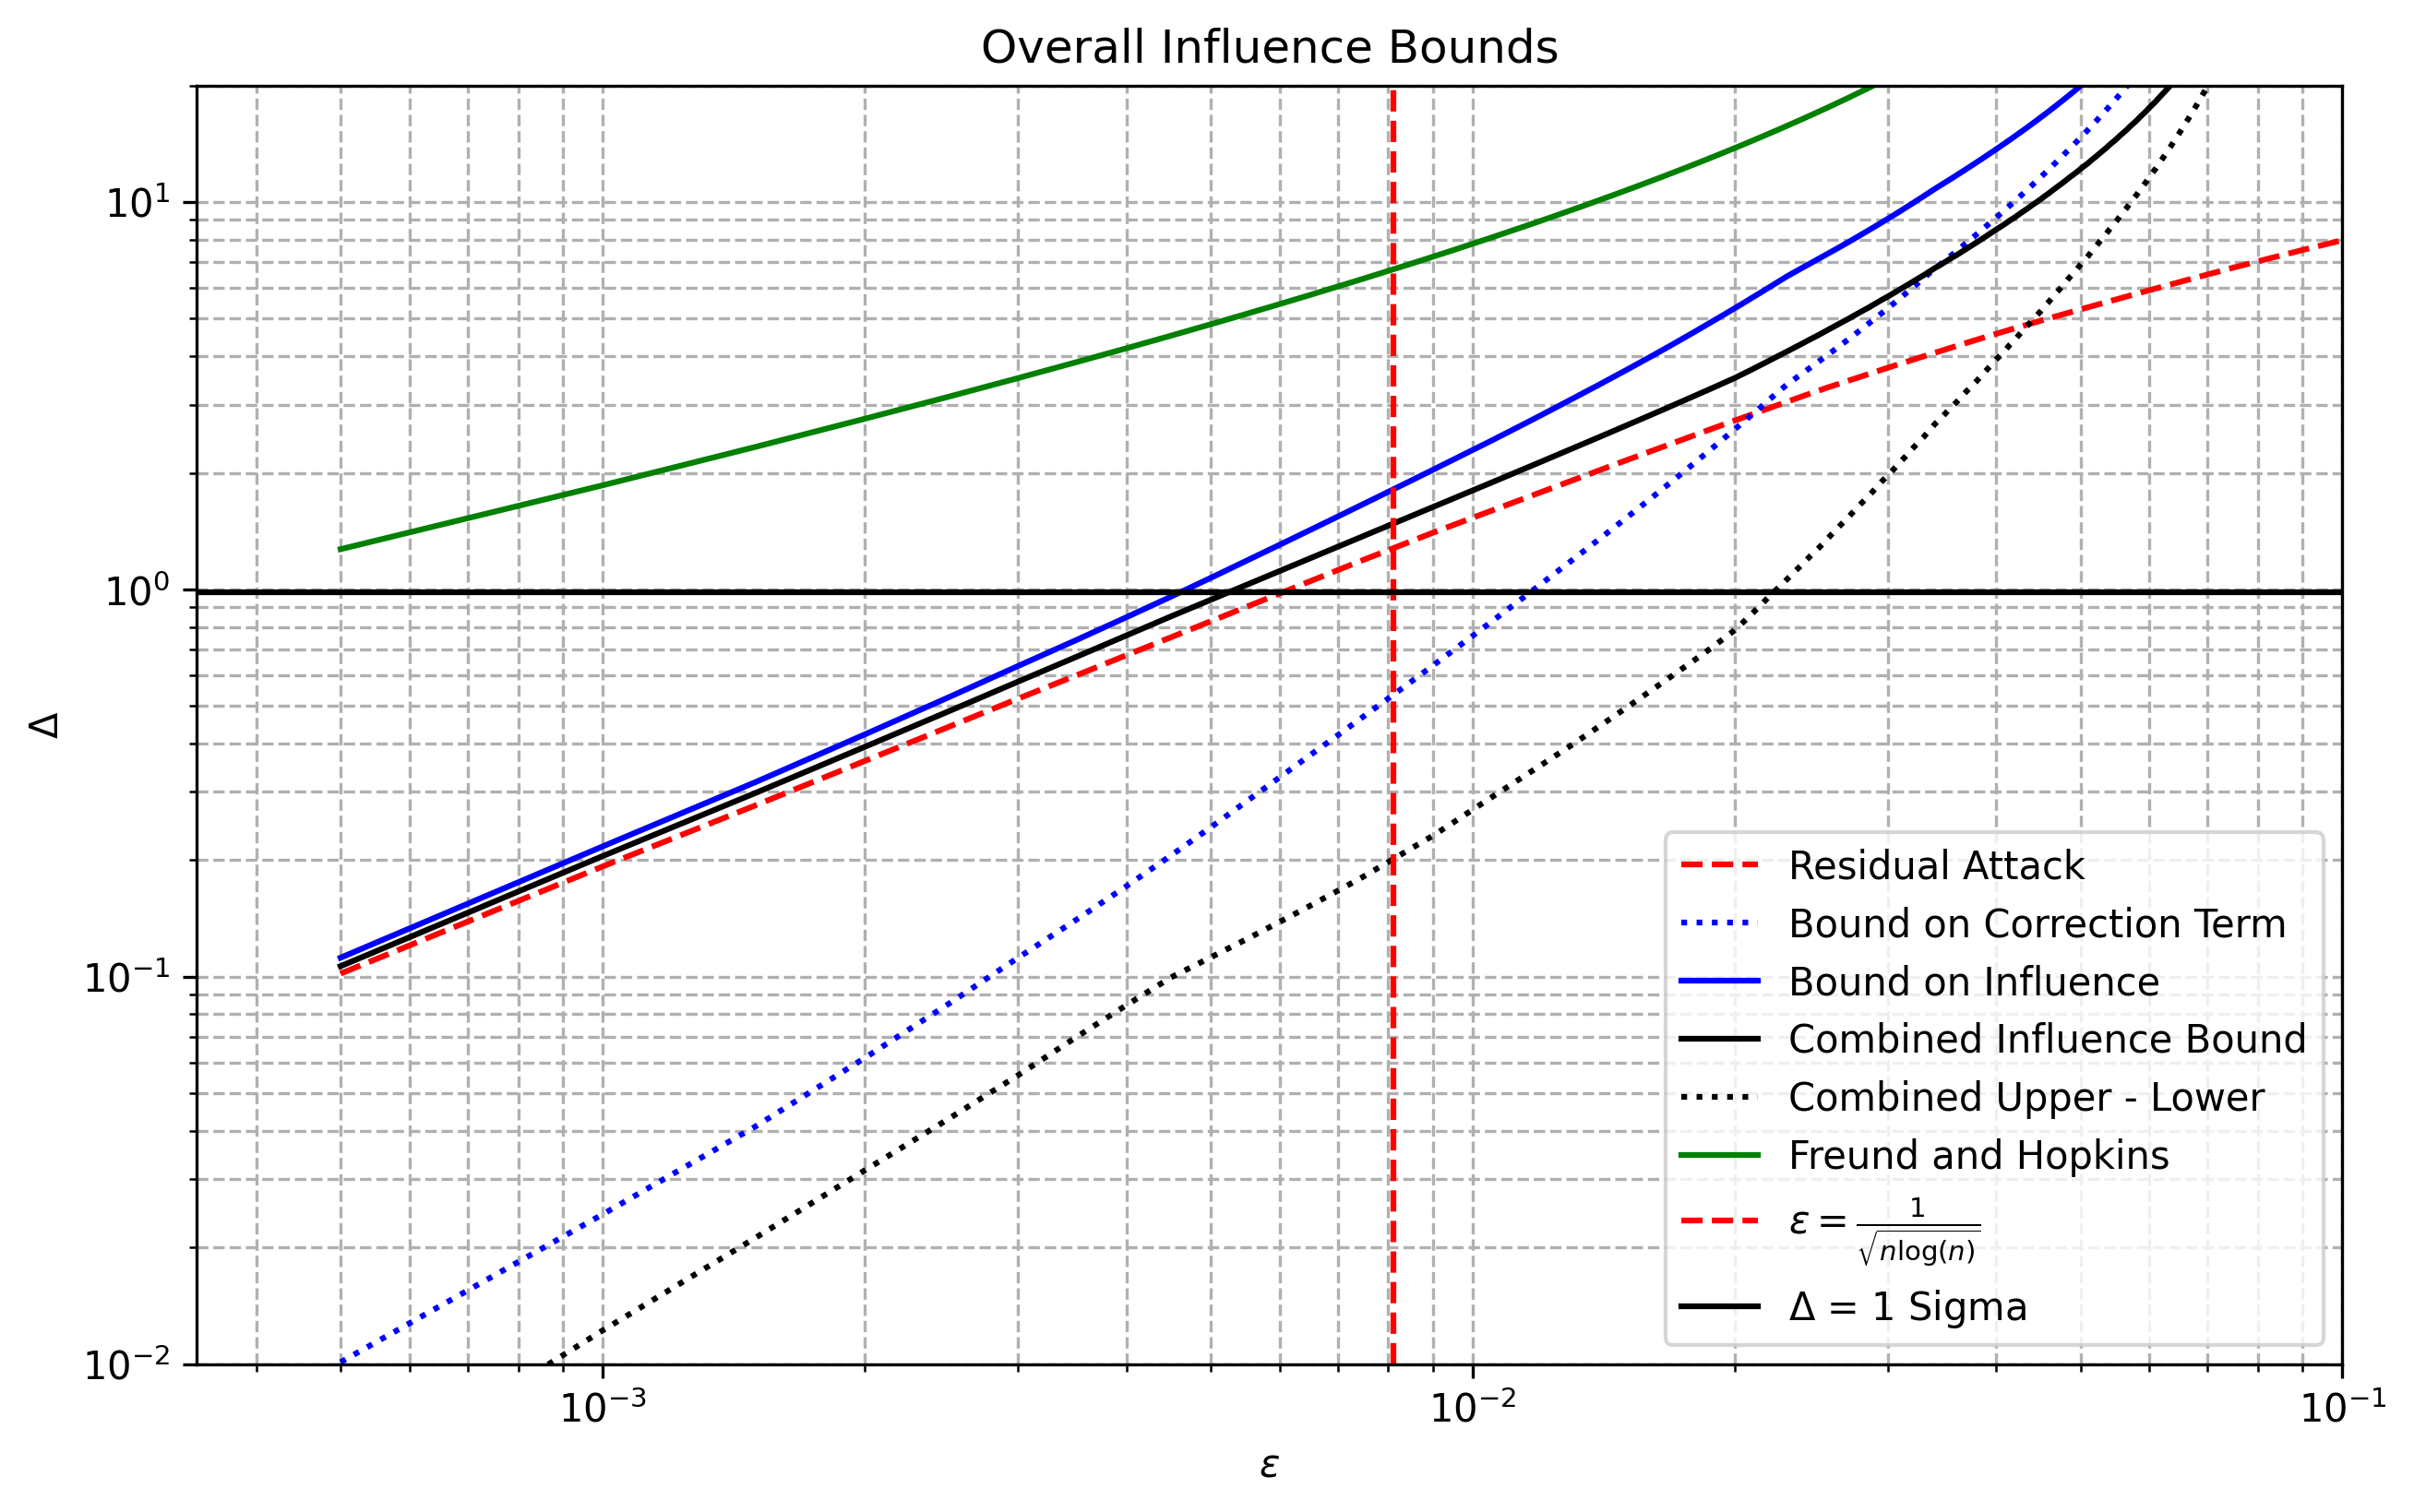

In [17]:
# Generate the main plot. Finally!!!
# We compare a several plots:
#   1. Residual Attack (just the effects due to change in the mean; we do not expect to prove bounds better than this).
#   2. Direct Bound (on correction term and on influence) - upper bound on Delta (and on Delta - RA) generated by bounding each of our error terms separately and then combining the bounds.
#   3. Improved Bounds - upper bounds generated by combining bounds on various linear combinations of the influence terms. This bound limits all error terms to use the same set of removed samples T.
#   4. The previous best known bound (Freund and Hopkins).


plt.figure(figsize=(10, 6), dpi=300)
plt.loglog(epsilons, residual_attacks, '--r', label='Residual Attack')


plt.loglog(
    epsilons[CS_bound < 1],
    covariance_bound[CS_bound < 1], 
    ':b', label='Bound on Correction Term'
)

plt.loglog(
    epsilons[CS_bound < 1],
    (covariance_bound+residual_attacks)[np.min(CS_bounds, axis=1) < 1], 
    '-b', label='Bound on Influence'
)


plt.loglog(
    epsilons[CS_bound < 1],
    combined_influence_bound[CS_bound < 1], 
    '-k', label='Combined Influence Bound'
)

plt.loglog(
    epsilons[CS_bound < 1],
    (combined_influence_bound - residual_attacks)[CS_bound < 1], 
    ':k', label='Combined Upper - Lower'
)

plt.loglog(
    epsilons[C2 * epsilons < 1],
    freund_and_hopkins[C2 * epsilons < 1], 
    '-g', label='Freund and Hopkins'
)

plt.axvline(x=1/np.sqrt(num_samples*np.log(num_samples)), color='r', linestyle='--', label=r'$\varepsilon = \frac{1}{\sqrt{n \log(n)}}$')
# plt.axvline(x=1/dimension, color='r', linestyle='-', label=r'$\varepsilon = \frac{1}{d}$')

plt.axhline(y=beta_error_bars[0], color='k', linestyle='-', label=r'$\Delta$ = 1 Sigma')


plt.xlabel(r'$\varepsilon$')
plt.ylabel(r'$\Delta$')
plt.title('Overall Influence Bounds')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.ylim(1E-2, 20)
plt.xlim(plt.xlim()[0], 0.1)
plt.savefig('./results_on_gaussian.png')
plt.show()

In [18]:
# TODO: Everything below here is just fun extras.

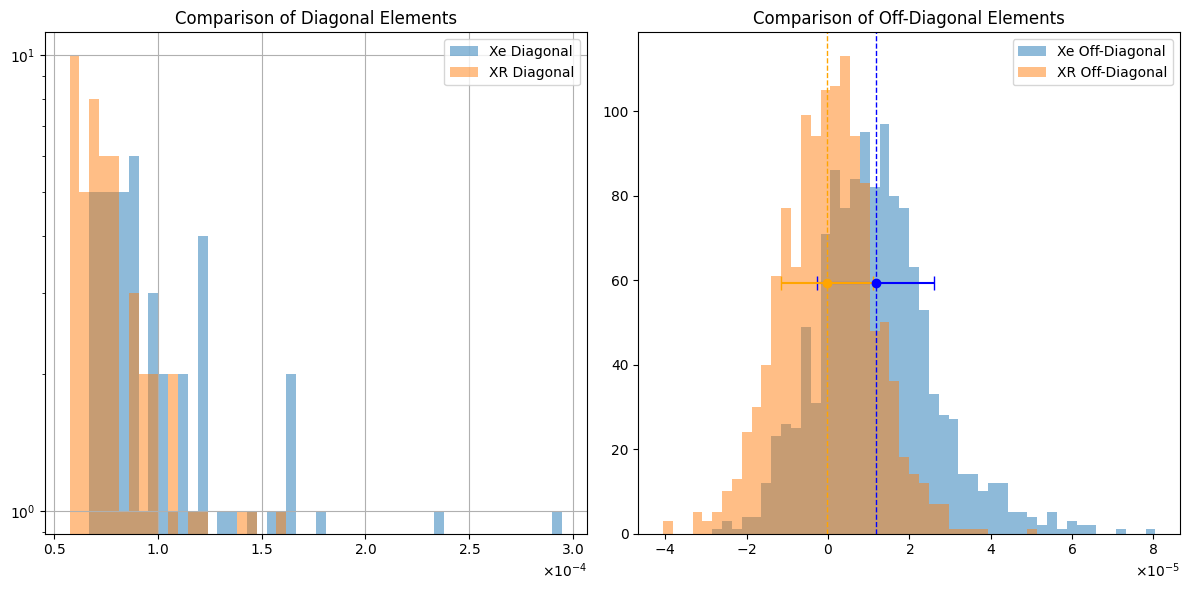

In [19]:
# Bounds on Xe = Norm{sum_i <X_i, e> X_i} and XR = Norm{sum_i R_i X_i} seemed to behave qualitatively different in some regimes
# To better explain this phenomena to myself, I generated a plot that shows that inner products of <X_i, e> X_i vectors tend to both
# larger and more positive (because the vectors are always aligned on the e axis). This causes the phase transitions between the 
# P1 algorithms to differ between the two use-cases (eg the triangle inequality algorithms are not sensitive to the signs of the inner 
# products).

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


# Identify the indices of the 100 largest diagonal elements
indices_Xe = np.argsort(np.diag(gram_matrix_Xe))[-50:]
indices_XR = np.argsort(np.diag(gram_matrix_XR))[-50:]

# Create submatrices focusing on the rows and columns of the 100 largest diagonal elements
submatrix_Xe = gram_matrix_Xe[np.ix_(indices_Xe, indices_Xe)]
submatrix_XR = gram_matrix_XR[np.ix_(indices_XR, indices_XR)] / num_samples

# Extract diagonal elements from the submatrices
diagonal_Xe = np.diag(submatrix_Xe)
diagonal_XR = np.diag(submatrix_XR)

# Extract off-diagonal elements (above the diagonal) from the submatrices
off_diagonal_Xe = submatrix_Xe[np.triu_indices_from(submatrix_Xe, k=1)]
off_diagonal_XR = submatrix_XR[np.triu_indices_from(submatrix_XR, k=1)]

# Function to compute the bin range for the 95% smallest samples
def compute_bin_range(elements_Xe, elements_XR):
    combined_elements = np.concatenate((elements_Xe, elements_XR))
    percentile_95 = np.percentile(np.abs(combined_elements), 99)
    # bin_range = (-percentile_95, percentile_95)
    bin_range = (min(combined_elements), max(combined_elements))
    return bin_range

# Compute the bin ranges
bin_range_diagonal = compute_bin_range(diagonal_Xe, diagonal_XR)
bin_range_off_diagonal = compute_bin_range(off_diagonal_Xe, off_diagonal_XR)

# Compute the bin ranges
bin_range_diagonal = compute_bin_range(diagonal_Xe, diagonal_XR)
bin_range_off_diagonal = compute_bin_range(off_diagonal_Xe, off_diagonal_XR)

# Plotting the histograms with the same bins and restricted ranges
plt.figure(figsize=(12, 6))

# Diagonal elements
plt.subplot(1, 2, 1)
plt.hist(diagonal_Xe, bins=50, range=bin_range_diagonal, alpha=0.5, label='Xe Diagonal')
plt.hist(diagonal_XR, bins=50, range=bin_range_diagonal, alpha=0.5, label='XR Diagonal')
plt.title('Comparison of Diagonal Elements')
plt.legend()
plt.yscale('log')
plt.grid()
plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

# Off-diagonal elements
plt.subplot(1, 2, 2)
plt.hist(off_diagonal_Xe, bins=50, range=bin_range_off_diagonal, alpha=0.5, label='Xe Off-Diagonal')
plt.hist(off_diagonal_XR, bins=50, range=bin_range_off_diagonal, alpha=0.5, label='XR Off-Diagonal')

# Calculate means and standard deviations
mean_Xe = np.mean(off_diagonal_Xe)
std_Xe = np.std(off_diagonal_Xe)
mean_XR = np.mean(off_diagonal_XR)
std_XR = np.std(off_diagonal_XR)

# Add vertical lines for means
plt.axvline(mean_Xe, color='blue', linestyle='dashed', linewidth=1)
plt.axvline(mean_XR, color='orange', linestyle='dashed', linewidth=1)

# Add error bars for standard deviations
plt.errorbar(mean_Xe, plt.ylim()[1] * 0.5, xerr=std_Xe, fmt='o', color='blue', capsize=5)
plt.errorbar(mean_XR, plt.ylim()[1] * 0.5, xerr=std_XR, fmt='o', color='orange', capsize=5)

plt.title('Comparison of Off-Diagonal Elements')
plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend()

plt.tight_layout()
plt.show()
